# Tracking simulated cells in 3D
---

Here we are simulating some dividing cells in 3D, tracking them and automatically calculating a lineage tree from the data using BayesianTracker.



In [1]:
%matplotlib inline

# temporarily added BayesianTracker to the path
import sys
sys.path.append('../btrack/')

# math
import numpy as np
import scipy.stats as stats
import scipy.integrate as integrate

# btrack components
import core
import btypes
import utils
from agents import AgentManager
from render import plot_tracks


/Users/arl/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[INFO][2019/04/11 01:58:45 PM] btrack (v0.2.8) library imported
[INFO][2019/04/11 01:58:45 PM] Loaded btrack: /Users/arl/Dropbox/Code/BayesianTracker/btrack/libs/libtracker.dylib


In [2]:
# instantiate agents
num_chaff = 500
num_frames = 1500

manager = AgentManager(num_agents=1, noise=0.1, periodic_boundary=False)
manager.simulate(num_frames)


Mitosis 1->2,3
Mitosis 3->4,5
Mitosis 2->6,7
Mitosis 4->8,9
Mitosis 5->10,11
Mitosis 7->12,13
Mitosis 6->14,15
Mitosis 8->16,17
Mitosis 9->18,19
Mitosis 12->20,21
Mitosis 13->22,23
Mitosis 14->24,25
Mitosis 15->26,27


In [3]:
def chaff(n_frames):
    """ Random observation """
    position = np.random.randint(0,high=1000, size=(3,))
    obj = btypes.PyTrackObject()
    obj.ID = int(1e5)
    obj.x = position[0]
    obj.y = position[1]
    obj.z = position[2]
    obj.t = np.random.randint(0,high=n_frames)
    obj.dummy = False
    obj.label = 0
    obj.probability = np.zeros((5,),dtype='float')
    return obj

### Start a BayesianTracker session

Get the simulated agents (dividing cells) and dropout some of the observations to challenge the tracker.

In [4]:
data = manager.get_data()

In [5]:
# shuffle the data (BT sorts it anyway) and dropout a fraction to simulate segmentation misses
dropout_rate = 0.01
import random
random.shuffle(data)
dropout = int(float(len(data))*dropout_rate)
for i in range(dropout):
    data.pop(0)

62


In [6]:
# count the number of metaphase (label=2) observations
dl = [d.label for d in data]
dl.count(2)

13

In [8]:
# start a session
with core.BayesianTracker() as trk:

    trk.append(data)

    trk.configure_from_file('MDCK_config.json')
    trk.return_kalman = True

    
    # trk.volume = ((0,1024),(0,1024),(0,1024))
    trk.track_interactive(step_size=500)
    
    # get the tracks
    tracks = trk.tracks

    
    # get the imaging volume (xyzt)
    volume = trk.volume

    # generate some hypotheses and optimise
    hypotheses = trk.hypotheses()
    trk.optimise()
    
    # get the optimized tracks
    tracks2 = trk.tracks



[INFO][2019/04/11 01:58:45 PM] Starting BayesianTracker session
[INFO][2019/04/11 01:58:45 PM] Loading motion model: MDCK_motion
[INFO][2019/04/11 01:58:45 PM] Loading hypothesis model: MDCK_hypothesis
[INFO][2019/04/11 01:58:45 PM] Setting maximum XYZ search radius to 100.00...
[INFO][2019/04/11 01:58:45 PM] Starting tracking... 
[INFO][2019/04/11 01:58:45 PM] Tracking objects in frames 0 to 499 (of 1509)...
[INFO][2019/04/11 01:58:45 PM]  - Timing (Bayesian updates: 0.01ms, Linking: 0.01ms)
[INFO][2019/04/11 01:58:45 PM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2019/04/11 01:58:45 PM]  - Stats (Active: 2, Lost: 5, Conflicts resolved: 3)
[INFO][2019/04/11 01:58:45 PM] Tracking objects in frames 500 to 999 (of 1509)...
[INFO][2019/04/11 01:58:45 PM]  - Timing (Bayesian updates: 0.02ms, Linking: 0.04ms)
[INFO][2019/04/11 01:58:45 PM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2019/04/11 01:58:45 PM]  - Stats (Active: 6, Lost: 37, Conflicts resolved: 18)
[INFO][

In [9]:
tracks == tracks2

False

In [10]:
print volume


[(176.91618784042353, 630.8724091531145), (70.88081354484024, 638.1385556759299), (483.84400378006455, 535.8982317977365), [0, 1508L]]


In [25]:
# count how many divisions we see
mitotic_tracks = [trk for trk in tracks2 if trk.fate==4]
for t in mitotic_tracks: print t.ID,'->', t.children

7 -> [13, 12]
12 -> [21, 20]
1 -> [2, 3]
2 -> [7, 6]
6 -> [11, 10]
3 -> [4, 5]
4 -> [8, 9]
8 -> [14, 15]
10 -> [16, 17]
13 -> [18, 19]


### Plot the trajectories and the original data
---

Plot the output of the tracking...

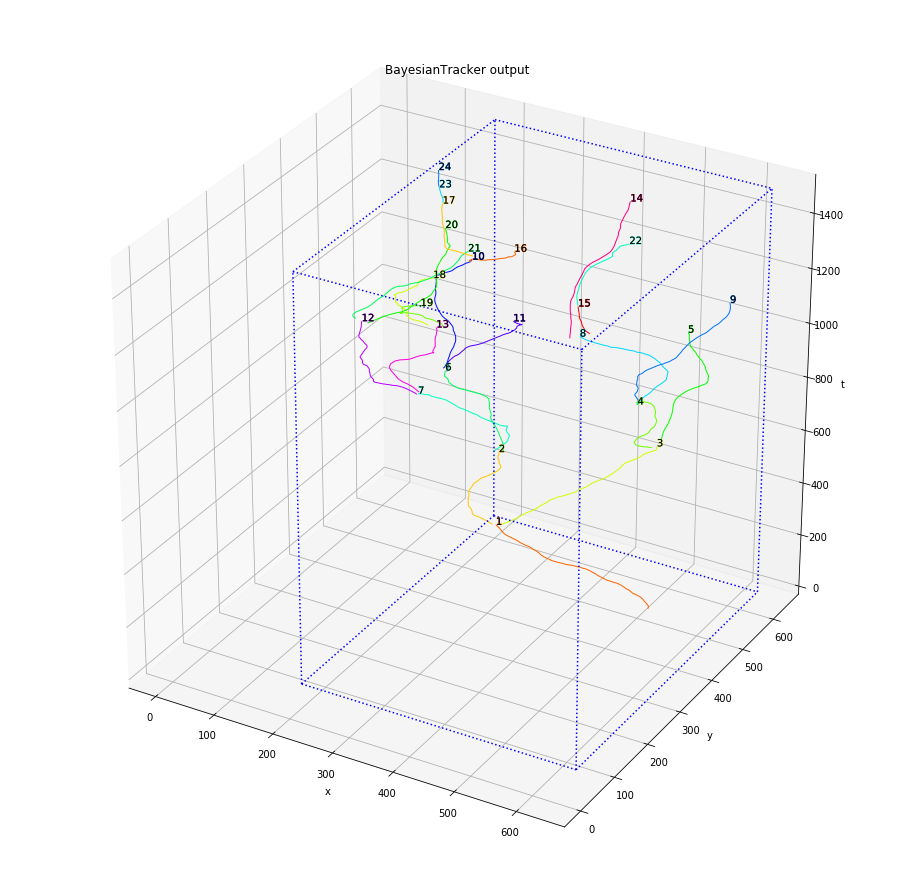

In [23]:
plot_tracks(tracks, order='xyt', box=volume, cmap=plt.get_cmap('hsv'), labels=True)

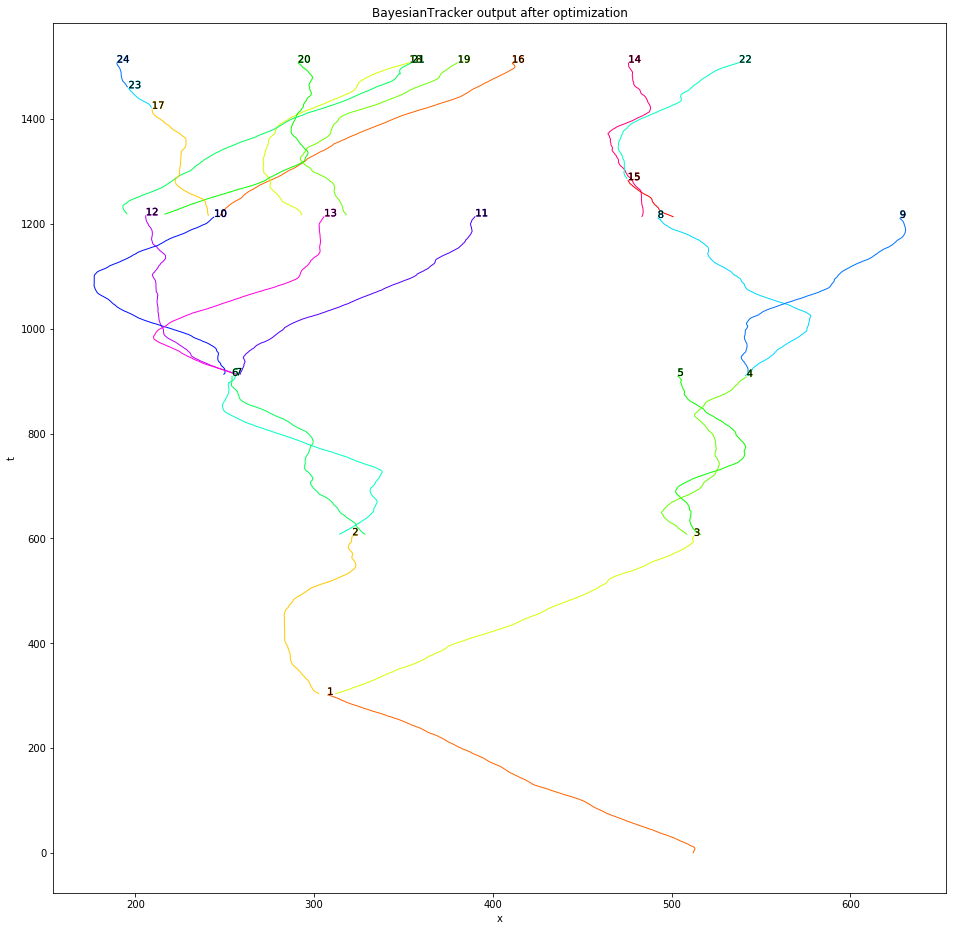

In [15]:
plot_tracks(tracks2, order='xt', box=volume, cmap=plt.get_cmap('hsv'), labels=True, title='BayesianTracker output after optimization')

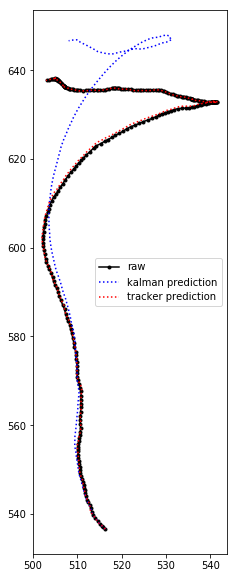

In [16]:
trk = tracks[0]


kal_mu_x = trk.kalman(1)
kal_mu_y = trk.kalman(2)
kal_pred_x = trk.kalman(13)
kal_pred_y = trk.kalman(14)

#a = agents[0]

plt.figure(figsize=(16,10))
plt.plot(trk.x,trk.y,'k.-')
# plt.plot(trk2.x,trk2.y,'k-')
plt.plot(kal_mu_x, kal_mu_y,'b:')
plt.plot(kal_pred_x, kal_pred_y,'r:')
plt.axis('image')
plt.legend(['raw', 'kalman prediction', 'tracker prediction'])
plt.show()


### inspect a tracklet

In [17]:
def inspect(trk_ID):
    trk = tracks2[trk_ID]
    dims = ['x','y','z']
    plt.figure(figsize=(16,10))
    for n, d in enumerate(dims):
        plt.subplot(3,1,n+1)
        mu = trk.kalman(n+1)
        cov = trk.kalman(4+n*3+n) # argh! complex indexing
        plt.errorbar(trk.kalman(0), mu, yerr=3.*cov, color='lightgrey')
        plt.plot(trk.kalman(0), mu, color='b')
        plt.xlabel('Time (frames)')
        plt.ylabel(r'{0:s} (Pixels $\pm \sigma_{0:s}^2$)'.format(d))
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.autoscale(enable=True, axis='y', tight=True)
    plt.show()

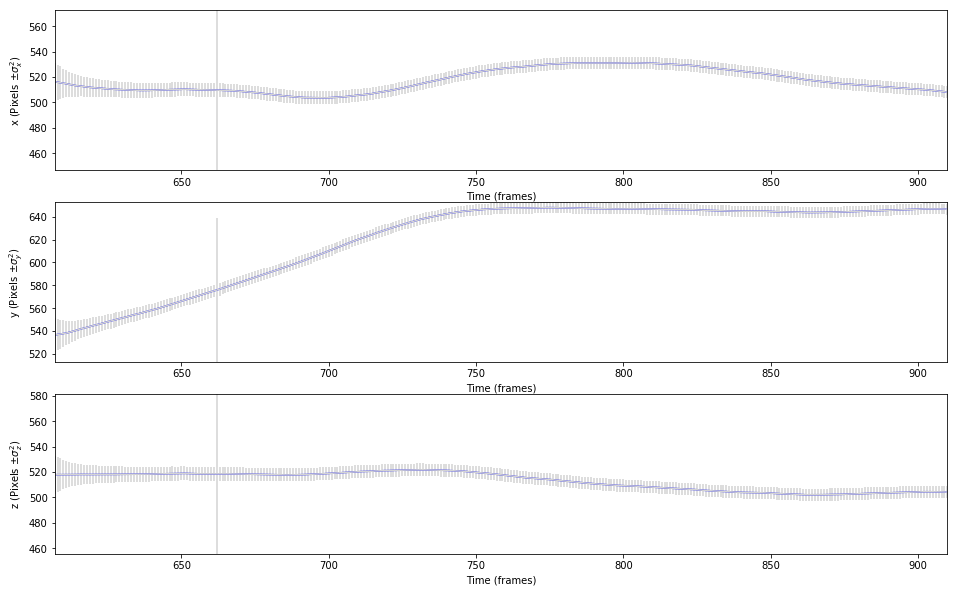

In [18]:
inspect(0)

### Automatically calculate the lineage tree from the data

Plot the binary tree using the built in plotter

In [19]:
from optimise import lineage

In [20]:
lineage_tree = lineage.LineageTree(tracks2)

In [21]:
trees = lineage_tree.create()

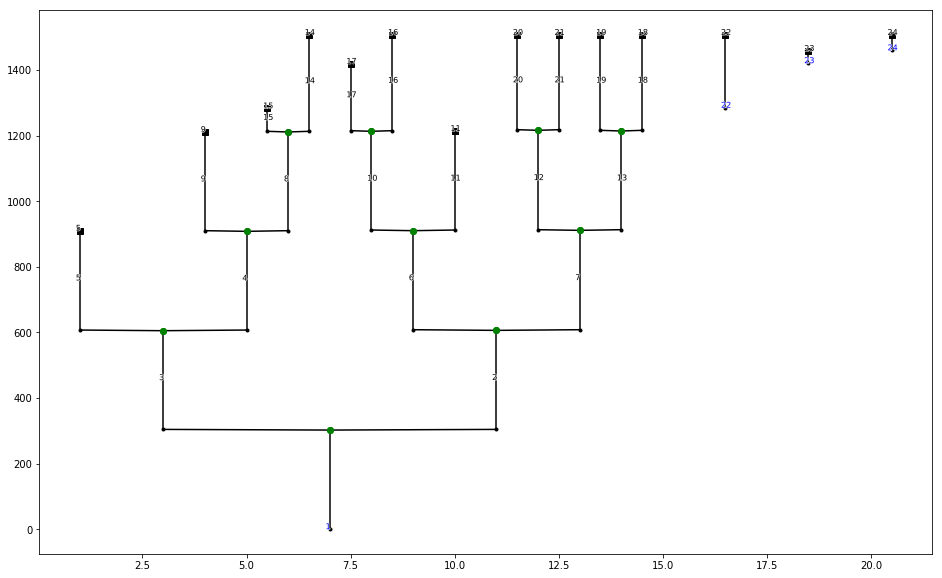

In [22]:
plt.figure(figsize=(16,10))
lineage_tree.plot()